# Gradient Boosted Trees Model

## Importing Relevant Libraries

In [11]:
import numpy as np
import math
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf
import numpy as np
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import *
from pyspark.sql.types import *
from pyspark.ml.linalg import *
from pyspark.sql.functions import *
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import PipelineModel
from pyspark.ml.stat import Correlation
import seaborn as sns
import pickle
import os
import matplotlib.pyplot as plt
from pyspark.ml.tuning import ParamGridBuilder
import pickle

## Reading Relevant csv files to Spark Dataframe

In [12]:
# Reading train_features.csv

# File location and type
file_location = "../../lish-moa/train_features.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
features_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [13]:
# Reading train_targets_scored.csv

# File location and type
file_location = "../../lish-moa/train_targets_scored.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
targets_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

## Data  Cleaning and Pre-Processing

### 1. Dropping samples with cp_type = 'ctl_vehicle' (placebo group would have no activations in any MoAs) 

In [14]:
# Dropping samples with cp_type = 'ctl_vehicle' (placebo group would have no activations in any MoAs) 
features_and_targets = features_data.join(targets_data, features_data.sig_id == targets_data.sig_id, how='inner').drop(targets_data.sig_id)
features_and_targets = features_and_targets.filter("cp_type = 'trt_cp'")

### 2. One Hot Encoding nominal feature 'cp_dose'
We use **One-Hot-Encoding** to encode the categorical cp_dose variable. We then get two numerical columns that are indicators for the cp_dose classes, and we drop the original cp_dose variable to avoid having the same variables in the dataset.

In [15]:
# One hot encoding cp_dose

# Indexing different categories in cp_type and storing in column 'cp_type_index'
string_indexer = StringIndexer(inputCol = 'cp_dose', outputCol = 'cp_dose_index')
features_and_targets = string_indexer.fit(features_and_targets).transform(features_and_targets).drop('cp_dose')

# One hot encoded and stored in cp_type_vector column
encoder = OneHotEncoder(inputCols=['cp_dose_index'],
                        outputCols=['cp_dose'], dropLast = False)

features_and_targets = encoder.fit(features_and_targets).transform(features_and_targets).drop('cp_dose_index')

### 3. Label Encoding ordinal feature 'cp_time' (treatment time)
We also label encode the cp_time variable to represent cardinality. 

In [16]:
# Label Encoding cp_time

# Assembling input columns to be label encoded to a vector 
assembler = VectorAssembler(inputCols = ['cp_time'], outputCol = 'cp_time_vector')
features_and_targets = assembler.transform(features_and_targets).drop('cp_time')

# Min-Max Scaler to label encode
mm_scaler = MinMaxScaler(inputCol = 'cp_time_vector', outputCol = 'cp_time_scaled_vector', min = 0, max = 2)
features_and_targets = mm_scaler.fit(features_and_targets).transform(features_and_targets).drop('cp_time_vector')

# UDF to transform encoded vector to scaler value 
firstElement=udf(lambda v:float(v[0]),FloatType())

features_and_targets = features_and_targets.withColumn('cp_time', firstElement(features_and_targets['cp_time_scaled_vector'])).drop('cp_time_scaled_vector')

## Stratified Train-Test Split
The idea is that first every combination of target label vector is encoded, and then stratified train-test split is
done based on that encoded value. In the scenario, there would be some samples for all possible different 
combinations of target labels in both train and test set.


In [17]:

# udf which converts a label vector to string i.e. a string contating all labels seperated by ' '
def vector_to_string(a):
  s=''
  for i in a:
    s = s + str(i) + ' '
  s.strip()
  return s
    
  
vector_to_string = udf(vector_to_string)   
spark.udf.register("vector_to_string", vector_to_string)

# Target columns names
target_names = []
for feature in targets_data.columns:
  if feature != 'sig_id':
    target_names.append(feature)

# converting label vectors to string i.e. a string contating all labels seperated by ' ' and storing into 'target_vector' column    
temp_df = features_and_targets.withColumn('target_vector', (vector_to_string(array([features_and_targets[col] for col in target_names])))).select(['sig_id', 'target_vector'])

# Encoding different possible combinations of target labels and storing the encoded value to 'target' column
string_indexer = StringIndexer(inputCol = 'target_vector', outputCol = 'target')
string_indexer_model = string_indexer.fit(temp_df)
temp_df = string_indexer_model.transform(temp_df).drop('target_vector')

# Joining features and targets data on 'sig_id'
data = features_and_targets.join(temp_df, features_and_targets.sig_id == temp_df.sig_id, how = 'inner').drop(temp_df.sig_id)

# Defining split ratio (80-20) for each unique value of target labels encoding (target)
unique_targets = data.select('target').distinct().collect()
fraction = {}
split_ratio = 0.2
for row in unique_targets:
  fraction[row.target] = split_ratio
  
# Startified train-test split
test_data = data.sampleBy('target', fractions=fraction, seed = 0)
data.createOrReplaceTempView('data_table')
test_data.createOrReplaceTempView('test_data_table')
train_data = spark.sql('select * from data_table as t1 where t1.sig_id not in (select t2.sig_id from test_data_table as t2)') 

# Asserting no data leakage
train_data.createOrReplaceTempView('train_data_table')
count = spark.sql('select * from train_data_table as t1 where t1.sig_id in (select t2.sig_id from test_data_table as t2)').count()
assert count == 0

# Dropping encoded target labels from both train and test
train_data = train_data.drop('target')
test_data = test_data.drop('target')

In [18]:
gene_feature_names = [] # list containing gene expression names
cell_feature_names = [] # list containing cell viability names

for i in range(772):
  gene_feature_names.append('g-' + str(i))

for i in range(100):
  cell_feature_names.append('c-' + str(i))

other_feature_names = ['sig_id', 'cp_type', 'cp_time', 'cp_dose'] # list containing other feature names

target_names = [col for col in train_data.columns if col not in gene_feature_names + cell_feature_names + other_feature_names] # list containing target names

## Feature Engineering

### Engineering new features: max and min values for gene expression and cell viability data

In [15]:
# Engineering new features: max and min values for gene expression and cell viability data

max_gene_train_df = train_data.withColumn("gene_max", F.greatest(*gene_feature_names)).select('sig_id', 'gene_max')
min_gene_train_df = train_data.withColumn("gene_min", F.least(*gene_feature_names)).select('sig_id', 'gene_min')
max_cell_train_df = train_data.withColumn("cell_max", F.greatest(*cell_feature_names)).select('sig_id', 'cell_max')
min_cell_train_df = train_data.withColumn("cell_min", F.least(*cell_feature_names)).select('sig_id', 'cell_min')

max_gene_test_df = test_data.withColumn("gene_max", F.greatest(*gene_feature_names)).select('sig_id', 'gene_max')
min_gene_test_df = test_data.withColumn("gene_min", F.least(*gene_feature_names)).select('sig_id', 'gene_min')
max_cell_test_df = test_data.withColumn("cell_max", F.greatest(*cell_feature_names)).select('sig_id', 'cell_max')
min_cell_test_df = test_data.withColumn("cell_min", F.least(*cell_feature_names)).select('sig_id', 'cell_min')

## Feature Selection

### Using correlation map to infer about highly correlated gene expressions and cell viability features in the train set

In [9]:
# Finding correalation matrix among gene expressions and cell viability data in the train set

cont_features = gene_feature_names + cell_feature_names
cont_features_df = train_data.select(cont_features)

va = VectorAssembler(inputCols = cont_features, outputCol = 'features')
cont_features_df = va.transform(cont_features_df)
corr_df = Correlation.corr(cont_features_df, 'features', 'pearson').collect()[0][0]

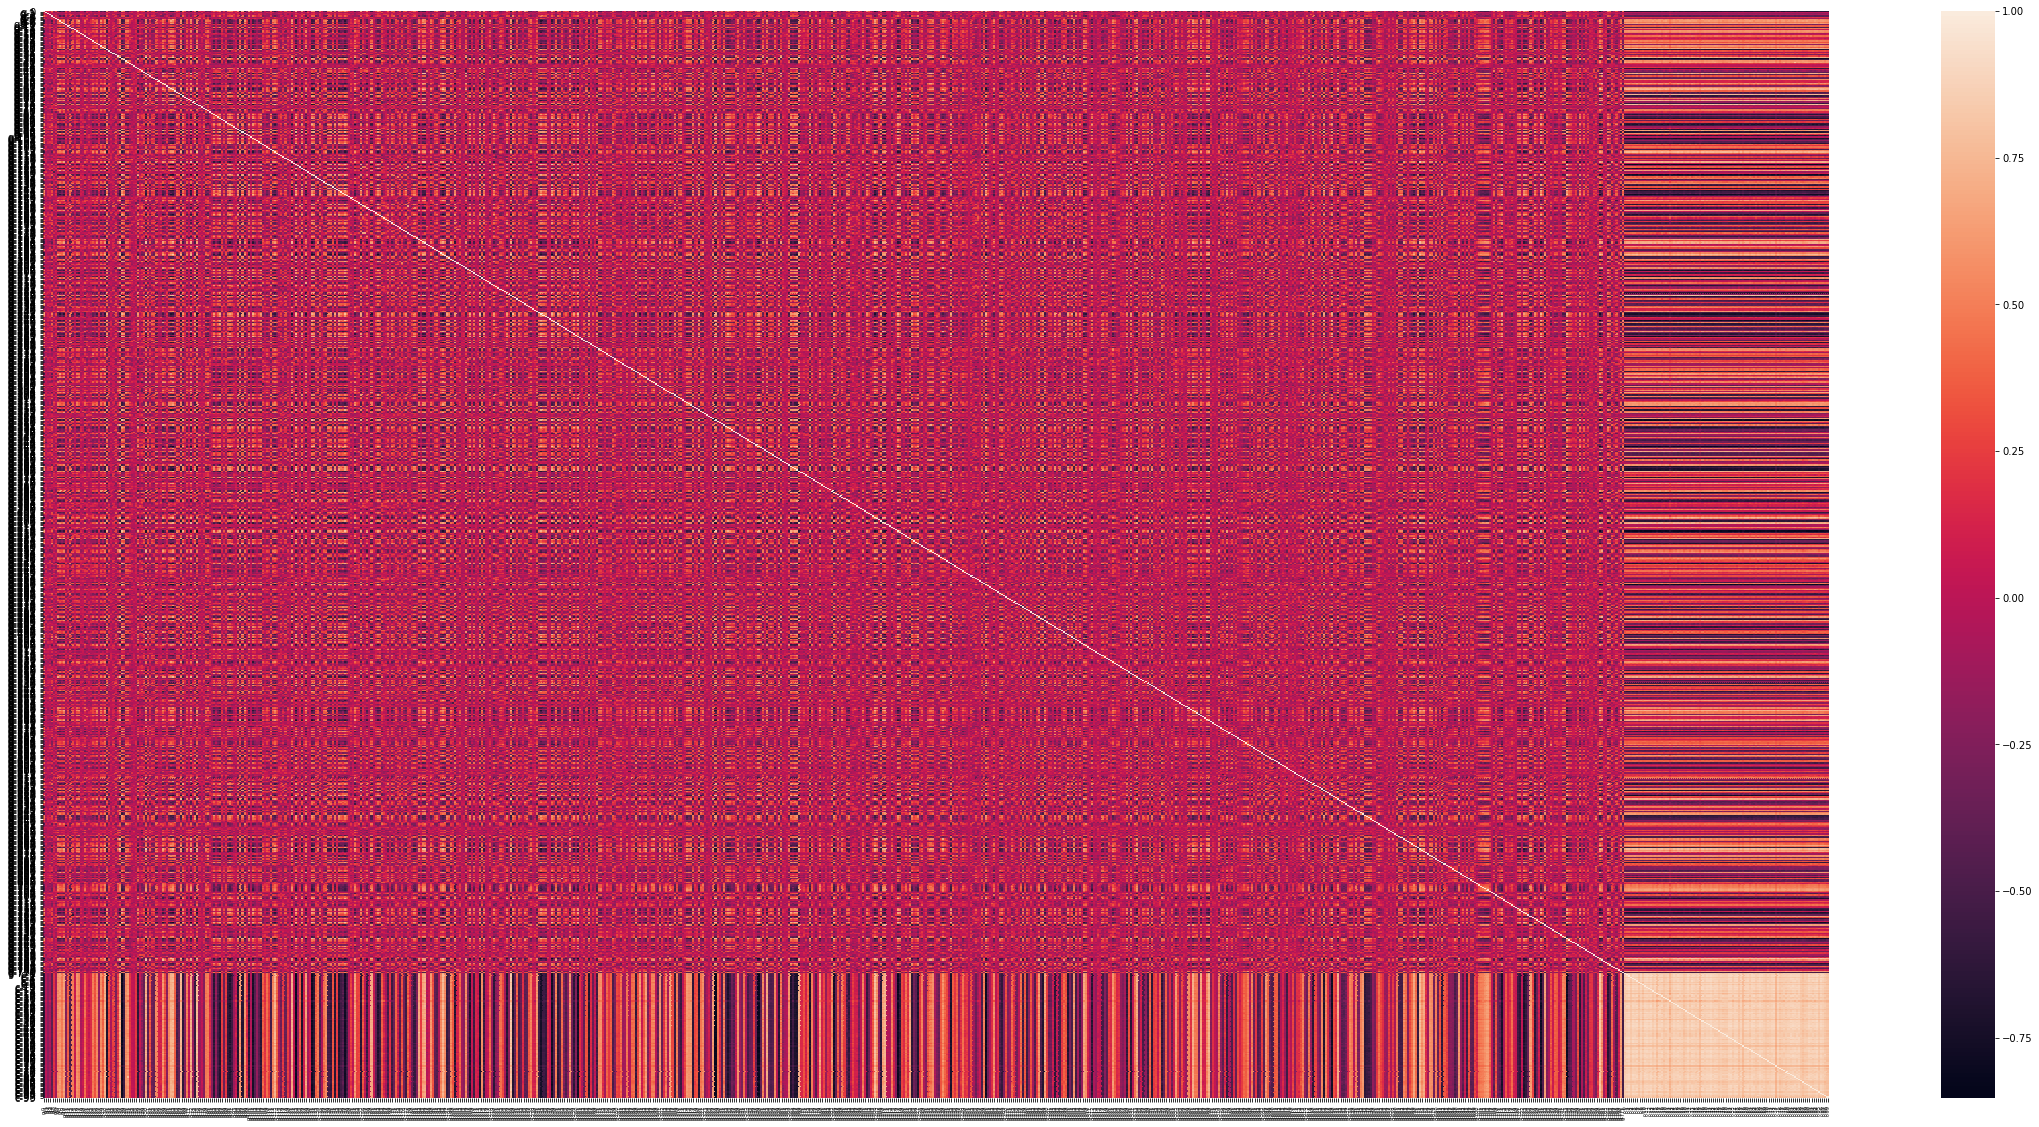

In [10]:
# Converting to correlation map to pandas df for visualization
corr_mat = corr_df.toArray()

plt.figure(figsize=(40,20))
sns.heatmap(corr_mat, xticklabels = gene_feature_names + cell_feature_names, yticklabels=gene_feature_names + cell_feature_names)
plt.xticks(rotation = 90, fontsize = 5)
plt.show()

#### As seen from the plot, some of the cell_viability features are highly corrleated

### Removing highly correlated continuous features

We remove the features if the magnitude of their correlation threshold exceeds 0.6. This is to reduce the dimensionality of the dataset and remove information unnecessary to the model. Based on this threshold, we end up removing around 300 features and we are left with 530 features.

In [11]:
threshold = 0.6 # correlation threshold 

# Removing features whose correlation < -threshold or > threshold
columns = np.full((corr_mat.shape[0], ), True, dtype = bool)
for i in range(corr_mat.shape[0]):
  for j in range(i+1, corr_mat.shape[0]):
    if not columns[j]:
      continue
    if corr_mat[i,j] >= threshold or corr_mat[i,j] <= -threshold :
      if columns[j]:
        columns[j] = False

selected_features = [(gene_feature_names + cell_feature_names)[i] for i, j in enumerate(columns) if j==True]

In [12]:
# Number of features (out of gene expressions and cell viability) retained after removing highly correlated features
len(selected_features)

530

## Data Pre-Processing

### 1. Selecting Non Redundant Features (as obtained from correaltion map) and Adding Engineered  Features 

In [13]:
train_data = train_data.select(other_feature_names + selected_features + target_names)
            .join(max_gene_train_df, on = 'sig_id', how = 'inner')
            .join(min_gene_train_df, on = 'sig_id', how = 'inner')
            .join(max_cell_train_df, on = 'sig_id', how = 'inner')
            .join(min_cell_train_df, on = 'sig_id', how = 'inner')
            
test_data = test_data.select(other_feature_names + selected_features + target_names)
            .join(max_gene_test_df, on = 'sig_id', how = 'inner')
            .join(min_gene_test_df, on = 'sig_id', how = 'inner')
            .join(max_cell_test_df, on = 'sig_id', how = 'inner')
            .join(min_cell_test_df, on = 'sig_id', how = 'inner')

In [14]:
# Updating selected features to include engineered features a
selected_features = selected_features + ['gene_max', 'gene_min', 'cell_max', 'cell_min']

### 2. Standardizing all the Continuous Features 
Most of the features are already 0-mean, but we are doing this to ensure they have unit variance also.

In [16]:
va = VectorAssembler(inputCols = selected_features, outputCol = 'feature_vector')

train_data = va.transform(train_data)
test_data = va.transform(test_data)

# Fitting Standard Scaler to train data
ss = StandardScaler(withMean=True, inputCol = 'feature_vector', outputCol='features')
ss_model = ss.fit(train_data)

# Transforming the train and test data with the fitted Standard Scaler model
train_data = ss_model.transform(train_data).drop('feature_vector')
test_data = ss_model.transform(test_data).drop('feature_vector')

### 3. Dimensionality Reduction through PCA 

In [17]:
k = 100 # Number of principal components
pca = PCA(k = k, inputCol='features', outputCol='pca_features')

# Fitting PCA to train data
pca_model = pca.fit(train_data)

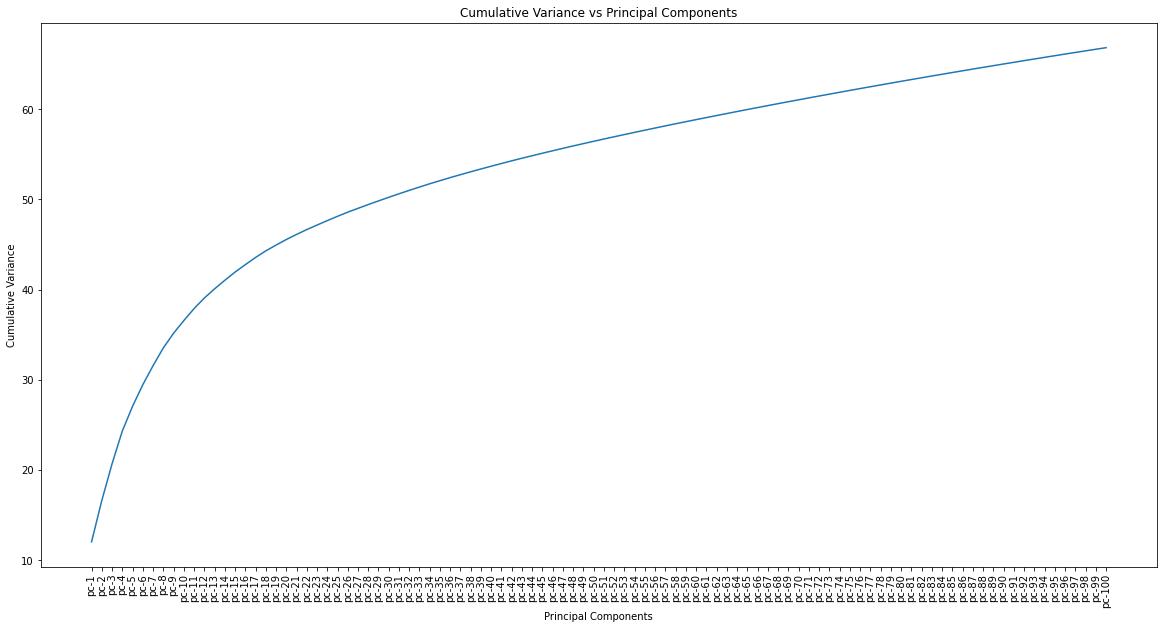

In [18]:
# Converting to numpy array for visulaization of Cumulative Variance of Principal Components
cum_var = np.cumsum(pca_model.explainedVariance.toArray())

xlabels = ['pc-' + str(i+1) for i in range(k)]
plt.figure(figsize=(20,10))
plt.plot(xlabels, cum_var*100)
plt.xticks(rotation = 90)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance vs Principal Components')
plt.show()

In [19]:
# Transforming the train and test data with the fitted PCA model 

train_data = pca_model.transform(train_data).drop('features')
test_data = pca_model.transform(test_data).drop('features')

In [20]:
# Caching the processed train and test data

train_data = train_data.select(['cp_time', 'cp_dose', 'pca_features'] + target_names).cache()
test_data = test_data.select(['cp_time', 'cp_dose', 'pca_features'] + target_names).cache()

In [21]:
train_data.show()

+-------+-------------+--------------------+---------------------------+----------------------+--------------+------------------------------+---------------------------------+------------------------------+--------------------------+-----------------------------+--------------------------+---------------------------+------------------------------+-------------+--------------------------------+-------------+--------------+---------+-------------------------+----------------------------+------------------+----------------------+-------------------------------+-----------------+--------------+----------+--------------+----------+-------------+------------+-----------+-------------+---------+-------------------+-------------------+--------------------+------------------------------------------+----------------------+----------------+--------------------+-----------------------+-------------------+-----------------------------------------+-----------------------------------------+----------

In [22]:
test_data.show()

+-------+-------------+--------------------+---------------------------+----------------------+--------------+------------------------------+---------------------------------+------------------------------+--------------------------+-----------------------------+--------------------------+---------------------------+------------------------------+-------------+--------------------------------+-------------+--------------+---------+-------------------------+----------------------------+------------------+----------------------+-------------------------------+-----------------+--------------+----------+--------------+----------+-------------+------------+-----------+-------------+---------+-------------------+-------------------+--------------------+------------------------------------------+----------------------+----------------+--------------------+-----------------------+-------------------+-----------------------------------------+-----------------------------------------+----------

## Training and Testing

In [23]:
# Binary Cross Entropy Loss (called when all the samples in the train set has label 0 (and hence no model is trained)
# otherwise inbuilt evaluator is used) 
def logloss(predictedProb, trueLabel):
    '''
    Function to calculate BCE
    
    Parameters:
    predictedProb: array of predicted probabilities
    trueLabel: array of true labels
    
    Returns:
    loss: float BCE loss
    '''
    loss = (-trueLabel*np.log(predictedProb + 10e-15) - (1-trueLabel)*(np.log(1-predictedProb))).mean()
    return loss

In [24]:
loss = 0
losses = [] # list to store loss/label
hamming_losses = [] # list to store progression of hamming loss after each label
untrained_labels = [] # list to store labels for which no model was trained (i.e. all samples in the train set had label 0)

# Looping over each target label and fitting a separate binary classifier
for i, label in enumerate(target_names):
    
  # Selecting relevant columns from the train and test data 
  X_train = train_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label])
  X_test = test_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label])

  one_count_train = X_train.filter(X_train[label] == 1).count() # Number of samples with label 1 in train set
  zero_count_train = X_train.filter(X_train[label] == 0).count() # Number of samples with label 0 in train set

  # if there are no samples in the train set with label 1, no model is trained, always output 0 for the label    
  if one_count_train == 0:
    untrained_labels.append(label) # logging the labels for which no model was trained
    # Predicted Probability will be 0 for the label in test data     
    n = X_test.count()
    prob = np.array([0]*n)
    label = np.array(X_test.select(label).toPandas())[:,0]
    l = logloss(prob, label) # loss for the test set
    print('No need to train the model. Will always output 0 for this label')
  
  # if there is atleast 1 sample in the train set with label 1, a binary classifier is fitted    
  else:
    '''
    Handling class imbalance: 
    
    If number of samples with label 0 >= 2* number of samples with label 1, then downsample (without replacement) 
    class 0 to half and then upsample (with replacement) class 1 to have same number as class 0
    '''
    factor = zero_count_train/one_count_train
    if factor>=2:
      # downsample without replacement  
      zero_samples = X_train.filter(X_train[label]==0).sample(fraction = 0.5, withReplacement = False,  seed = 0) 
      # upsample with replacement  
      one_samples = spark.createDataFrame(X_train.filter(X_train[label]==1).toPandas().sample(n = int(X_train.filter(X_train[label]==0).count()/2), replace = True,  random_state = 0))
      X_train = zero_samples.union(one_samples).orderBy(rand())
    
    # Assembleing features into a vector in train and test set
    va = VectorAssembler(inputCols = ['cp_time', 'cp_dose', 'pca_features'], outputCol = 'features')
    X_train = va.transform(X_train)
    X_test = va.transform(X_test)
    
    # Fitting a GBT model to the train set
    gbt = GBTClassifier(labelCol = label)
    print('Training GBT')
    gbtModel = gbt.fit(X_train)
    print('GBT Trained')
    
    # Testing the trained GBT model on the test set 
    pred_df = gbtModel.transform(X_test)
    evaluator = MulticlassClassificationEvaluator(labelCol=label, metricName='logLoss')
    l= evaluator.evaluate(pred_df) # test loss
  
  # Logging
  losses.append(l) # logging test loss/label
  print(f'Label Loss for {i}: {label} = {l}')
  loss+=l
  hamming_loss = loss/(i+1)
  hamming_losses.append(hamming_loss) # logging progression of hamming loss after every label 
  print(f'Hamming Loss after {i}: {label} = {hamming_loss}')
  d = {'losses': losses, 'untrained_labels': untrained_labels, 'hamming_losses': hamming_losses }
  # Writing the loss to a pickle file   
  f = open('data_untuned.pkl', 'wb')
  pickle.dump(d, f)
  f.close()  
  print('################################')

Training GBT
GBT Trained
Label Loss for 0: 5-alpha_reductase_inhibitor = 0.06247522902359907
Hamming Loss after 0: 5-alpha_reductase_inhibitor = 0.06247522902359907
################################
Training GBT
GBT Trained
Label Loss for 1: 11-beta-hsd1_inhibitor = 0.06245920061161403
Hamming Loss after 1: 11-beta-hsd1_inhibitor = 0.062467214817606545
################################
Training GBT
GBT Trained
Label Loss for 2: acat_inhibitor = 0.08356878860673383
Hamming Loss after 2: acat_inhibitor = 0.06950107274731564
################################
Training GBT
GBT Trained
Label Loss for 3: acetylcholine_receptor_agonist = 0.2248410104407507
Hamming Loss after 3: acetylcholine_receptor_agonist = 0.1083360571706744
################################
Training GBT
GBT Trained
Label Loss for 4: acetylcholine_receptor_antagonist = 0.3131136563661688
Hamming Loss after 4: acetylcholine_receptor_antagonist = 0.14929157700977327
################################
Training GBT
GBT Trained
Label

Training GBT
GBT Trained
Label Loss for 44: bacterial_dna_gyrase_inhibitor = 0.18689392094600654
Hamming Loss after 44: bacterial_dna_gyrase_inhibitor = 0.11882229362307911
################################
Training GBT
GBT Trained
Label Loss for 45: bacterial_dna_inhibitor = 0.19265979417218343
Hamming Loss after 45: bacterial_dna_inhibitor = 0.12042745667849442
################################
Training GBT
GBT Trained
Label Loss for 46: bacterial_membrane_integrity_inhibitor = 0.04463049410550901
Hamming Loss after 46: bacterial_membrane_integrity_inhibitor = 0.1188147553471543
################################
Training GBT
GBT Trained
Label Loss for 47: bcl_inhibitor = 0.07908020755418609
Hamming Loss after 47: bcl_inhibitor = 0.11798695226813412
################################
Training GBT
GBT Trained
Label Loss for 48: bcr-abl_inhibitor = 0.09275833909030216
Hamming Loss after 48: bcr-abl_inhibitor = 0.11747208261144368
################################
Training GBT
GBT Trained
Labe

Training GBT
GBT Trained
Label Loss for 87: fatty_acid_receptor_agonist = 0.07732829588865162
Hamming Loss after 87: fatty_acid_receptor_agonist = 0.12022715512859658
################################
Training GBT
GBT Trained
Label Loss for 88: fgfr_inhibitor = 0.09089381833771269
Hamming Loss after 88: fgfr_inhibitor = 0.11989756707476643
################################
Training GBT
GBT Trained
Label Loss for 89: flt3_inhibitor = 0.18968082335808895
Hamming Loss after 89: flt3_inhibitor = 0.12067293658902556
################################
Training GBT
GBT Trained
Label Loss for 90: focal_adhesion_kinase_inhibitor = 0.05111378195388059
Hamming Loss after 90: focal_adhesion_kinase_inhibitor = 0.11990855027435364
################################
Training GBT
GBT Trained
Label Loss for 91: free_radical_scavenger = 0.07288731889777715
Hamming Loss after 91: free_radical_scavenger = 0.1193974499333039
################################
Training GBT
GBT Trained
Label Loss for 92: fungal_squa

Training GBT
GBT Trained
Label Loss for 131: monoamine_oxidase_inhibitor = 0.15429501371289714
Hamming Loss after 131: monoamine_oxidase_inhibitor = 0.11844895070362826
################################
Training GBT
GBT Trained
Label Loss for 132: monopolar_spindle_1_kinase_inhibitor = 0.05749886091780831
Hamming Loss after 132: monopolar_spindle_1_kinase_inhibitor = 0.11799067935185518
################################
Training GBT
GBT Trained
Label Loss for 133: mtor_inhibitor = 0.09072572805193155
Hamming Loss after 133: mtor_inhibitor = 0.11778720956603485
################################
Training GBT
GBT Trained
Label Loss for 134: mucolytic_agent = 0.10184204548590413
Hamming Loss after 134: mucolytic_agent = 0.11766909723951537
################################
Training GBT
GBT Trained
Label Loss for 135: neuropeptide_receptor_antagonist = 0.0732221323129739
Hamming Loss after 135: neuropeptide_receptor_antagonist = 0.11734228132093785
################################
Training GBT


Training GBT
GBT Trained
Label Loss for 174: ribonucleoside_reductase_inhibitor = 0.0710576787130155
Hamming Loss after 174: ribonucleoside_reductase_inhibitor = 0.11476794844193258
################################
Training GBT
GBT Trained
Label Loss for 175: rna_polymerase_inhibitor = 0.07368407839426967
Hamming Loss after 175: rna_polymerase_inhibitor = 0.11453451736211631
################################
Training GBT
GBT Trained
Label Loss for 176: serotonin_receptor_agonist = 0.27652449311988797
Hamming Loss after 176: serotonin_receptor_agonist = 0.11544971496526756
################################
Training GBT
GBT Trained
Label Loss for 177: serotonin_receptor_antagonist = 0.3408727308970567
Hamming Loss after 177: serotonin_receptor_antagonist = 0.1167161364030866
################################
Training GBT
GBT Trained
Label Loss for 178: serotonin_reuptake_inhibitor = 0.1174719855530885
Hamming Loss after 178: serotonin_reuptake_inhibitor = 0.11672035902403634
###############

In [25]:
with open('data_untuned.pkl', 'rb') as f:
    data = pickle.load(f)

In [33]:
# Writing other model artifacts to a pickle file 
data['train_data'] = train_data.toPandas()
data['test_data'] = test_data.toPandas()
data['variance'] = pca_model.explainedVariance.toArray()
data['cumulative_variance'] = cum_var
data['correlation_matrix'] = corr_mat
data['selected_features'] = selected_features

with open('data_untuned.pkl', 'wb') as f:
    pickle.dump(data, f)

##  Results

In [19]:
with open('data_untuned.pkl', 'rb') as f:
    data = pickle.load(f)

### 1. Plot of BCE loss for each target label in the test dataset

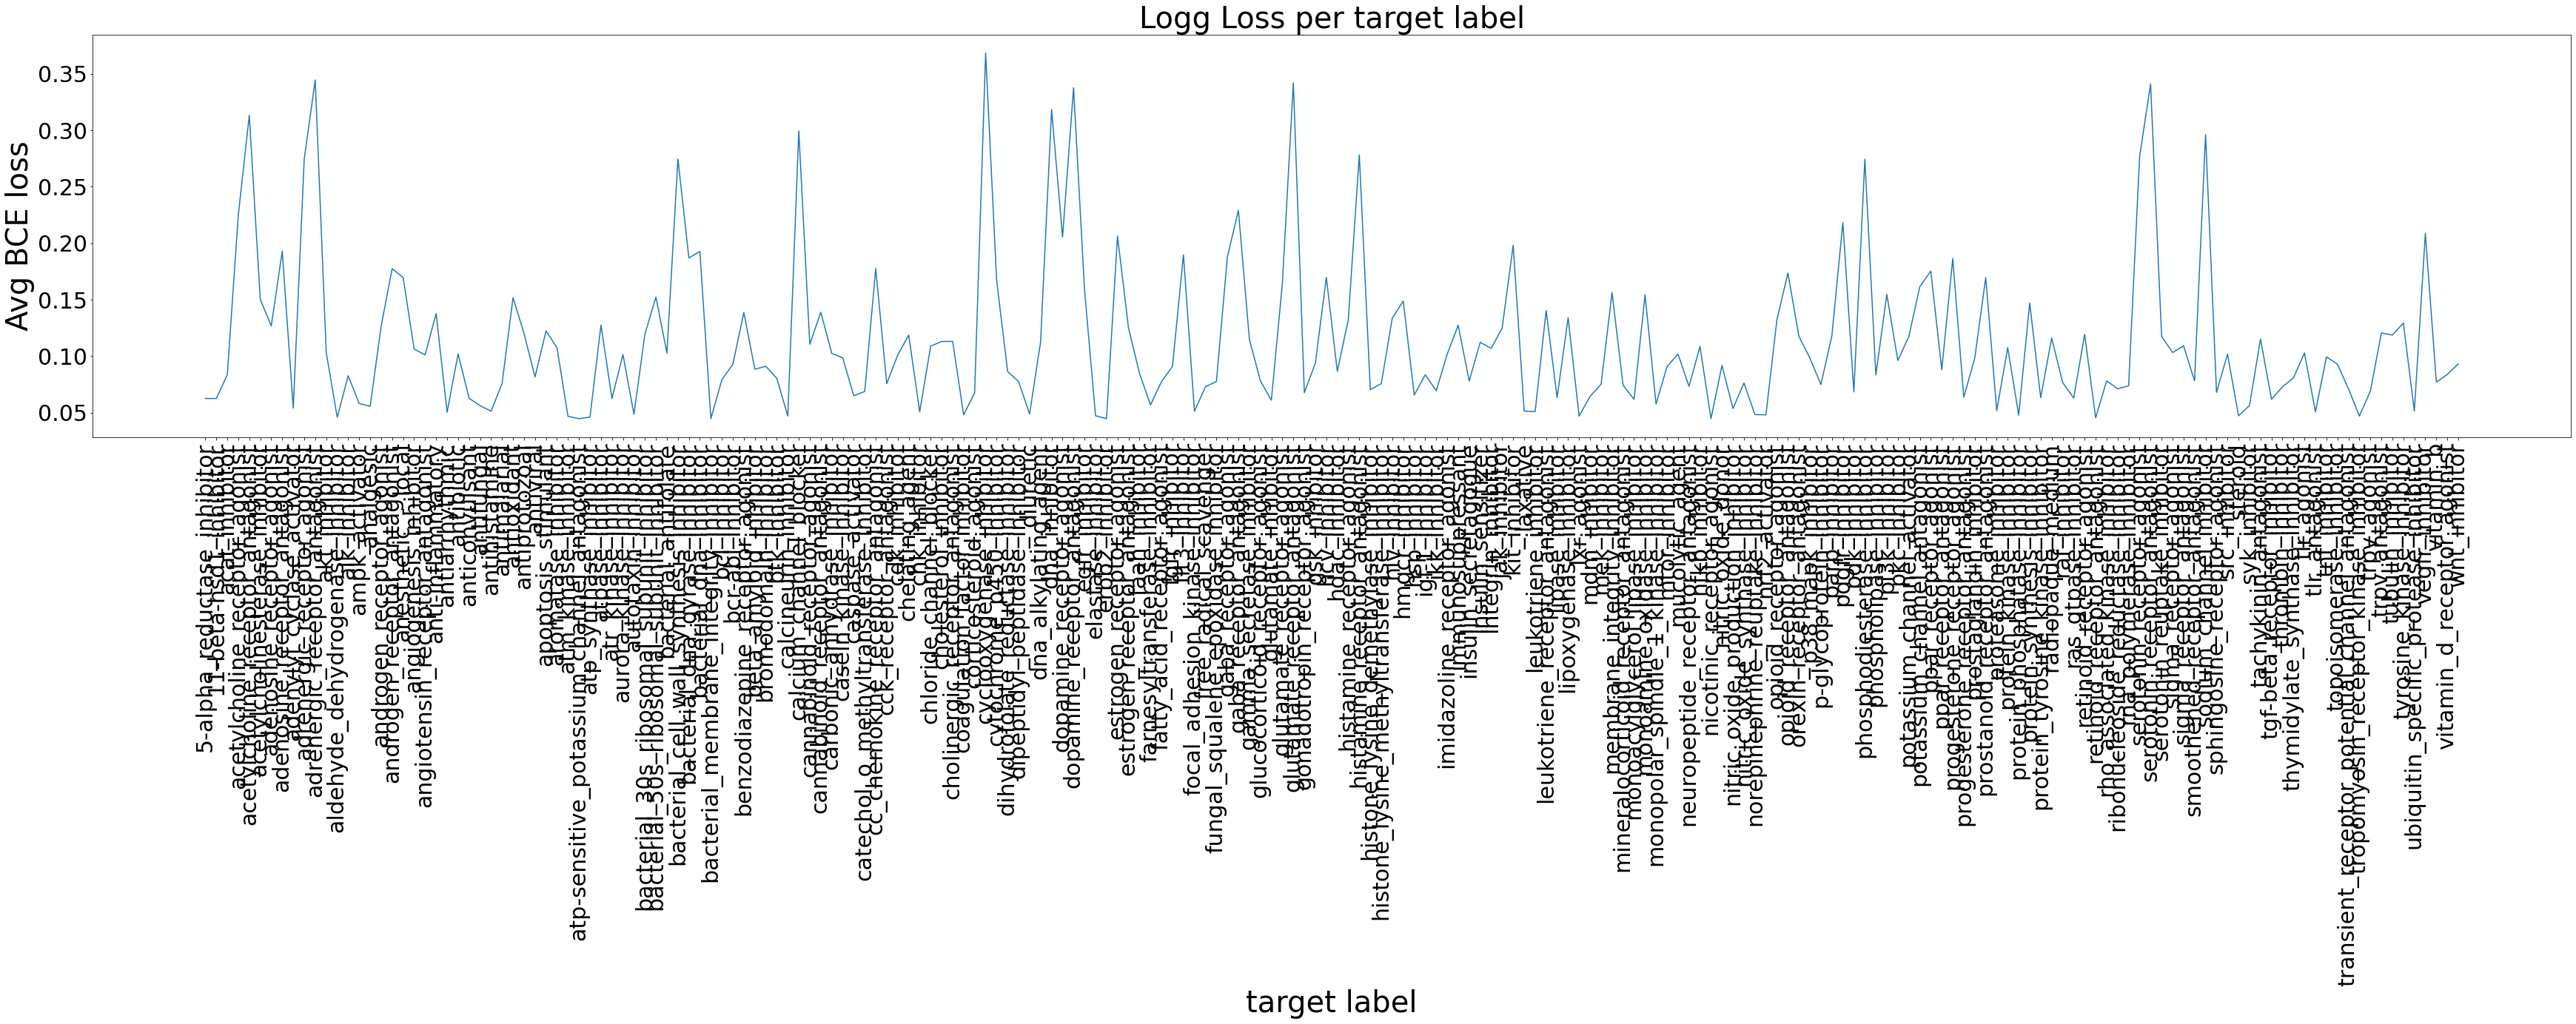

In [20]:
plt.figure(figsize = (60,10))
plt.plot(target_names, data['losses'])
plt.title('Logg Loss per target label', fontsize = 40)
plt.xlabel('target label', fontsize=40)
plt.ylabel('Avg BCE loss', fontsize = 40)
plt.xticks(rotation = 90, fontsize = 30)
plt.yticks(fontsize = 30)
plt.show()

### 2. Plot of Pogression of Hamming Loss after each target label in the test dataset

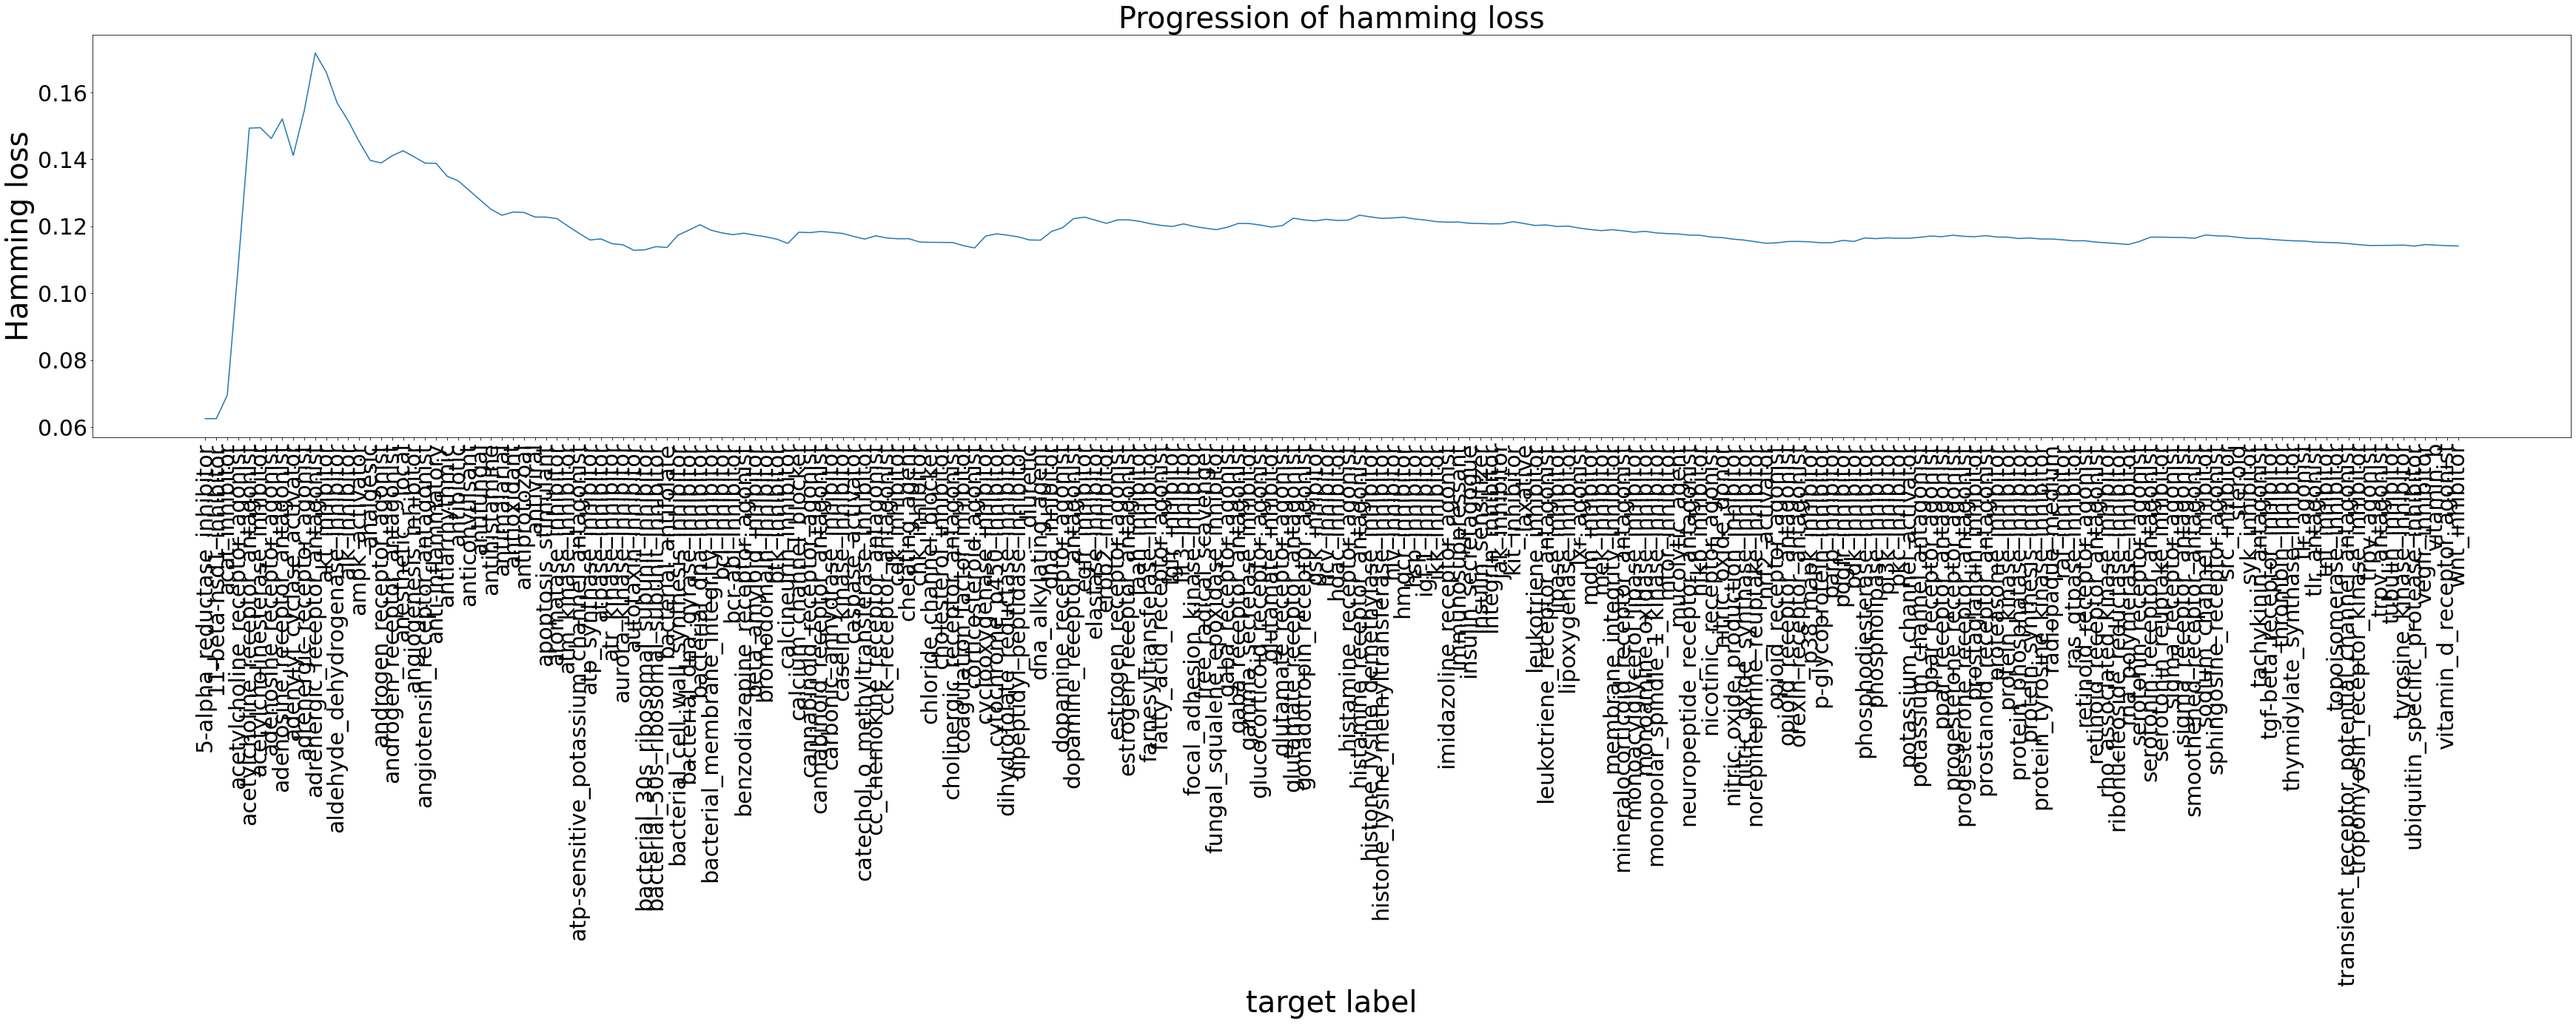

In [31]:
plt.figure(figsize = (60,10))
plt.plot(target_names, data['hamming_losses'])
plt.title('Progression of hamming loss', fontsize = 40)
plt.xlabel('target label', fontsize=40)
plt.ylabel('Hamming loss', fontsize = 40)
plt.xticks(rotation = 90, fontsize = 30)
plt.yticks(fontsize = 30)
plt.show()

### 3. Overall Hamming loss for the test set

In [9]:
print('Hamming loss for the test set: {}'.format(data['hamming_losses'][-1]))

Hamming loss for the test set: 0.11406681532552644


## Hyperparameter Tuning

## Stratified K-Fold Cross Validator

In [33]:
'''
Implementation of Stratified K-Fold Cross Validation: 

Adapted from: https://github.com/interviewstreet/spark-stratifier

Since train data is highly imbalanced, stratified cross validation approach is taken
'''
import itertools
import numpy as np
from pyspark import since, keyword_only
from pyspark.ml import Estimator, Model
from pyspark.ml.common import _py2java
from pyspark.ml.param import Params, Param, TypeConverters
from pyspark.ml.param.shared import HasSeed
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel
from pyspark.ml.util import *
from pyspark.ml.wrapper import JavaParams
from pyspark.sql.functions import rand
from functools import reduce
from multiprocessing.pool import ThreadPool

class StratifiedCrossValidator(CrossValidator):
  def stratify_data(self, dataset):
    """
    Returns an array of dataframes with the same ratio of passes and failures.

    Currently only supports binary classification problems.
    """

    epm = self.getOrDefault(self.estimatorParamMaps)
    numModels = len(epm)
    nFolds = self.getOrDefault(self.numFolds)
    split_ratio = 1.0 / nFolds

    passes = dataset[dataset['label'] == 1]
    fails = dataset[dataset['label'] == 0]

    pass_splits = passes.randomSplit([split_ratio for i in range(nFolds)])
    fail_splits = fails.randomSplit([split_ratio for i in range(nFolds)])
    
    '''
    For every split, if (number of samples with label 0)/(number of samples with label 1) > 2, downsample number of 
    samples with label 0 (without replacement) by half and then upsample number of samples with label 0 (with replacement)
    so as to have the same count as number of samples of label 0
    '''
    for i in range(len(pass_splits)):
      one_count_train = pass_splits[i].count()
      zero_count_train = fail_splits[i].count()
      factor = zero_count_train/one_count_train
      if factor > 2:
        fail_splits[i] = fail_splits[i].sample(fraction = 0.5, withReplacement = False,  seed = 0) 
        pass_splits[i] = spark.createDataFrame(pass_splits[i].toPandas().sample(n = fail_splits[i].count(), replace = True,  random_state = 0))
    
    
    stratified_data = [pass_splits[i].unionAll(fail_splits[i]) for i in range(nFolds)]

    return stratified_data

  def _fit(self, dataset):
    '''
    Fits the model with different hyperparameter settings, performs k fold cross validation to return the avg metrics
    , best model, best parameters etc.
    '''    
    est = self.getOrDefault(self.estimator) # estimator
    epm = self.getOrDefault(self.estimatorParamMaps) # dictionary of hyperparameters
    numModels = len(epm) # number of different hyperparameter settings
    eva = self.getOrDefault(self.evaluator)
    nFolds = self.getOrDefault(self.numFolds) # number of folds
    seed = self.getOrDefault(self.seed) # seeds
    metrics = [0.0] * numModels # list to store avg K-Fold metric score for each hyperparameter setting
    
    stratified_data = self.stratify_data(dataset) # Get stratified train-val splits
    
    '''
    Performinh K fold validtion, on stratified train-val split and returns the model with 
    '''
    for i in range(nFolds):
      train_arr = [x for j,x in enumerate(stratified_data) if j != i]
      train = reduce((lambda x, y: x.unionAll(y)), train_arr)
      validation = stratified_data[i]

      models = est.fit(train, epm)

      for j in range(numModels):
        model = models[j]
        metric = eva.evaluate(model.transform(validation, epm[j]))
        metrics[j] += metric/nFolds

    if eva.isLargerBetter():
      bestIndex = np.argmax(metrics)
    else:
      bestIndex = np.argmin(metrics)

    bestModel = est.fit(dataset, epm[bestIndex])
    return self._copyValues(CrossValidatorModel(bestModel, metrics))


## Training - K-Fold Cross Validation - Testing 

In [63]:
losses = [] # List to store BCE test loss every label
val_loss = [] # List of lists where each inside list stores avg K-fold validation loss for every hyperparameter setting
best_params = [] # list of dictionaries, where each dictinary stores the best hyperparameter values
total_loss = 0 # tracking the total loss after every label
hamming_losses = [] # list to store the progression of hamming loss

# Going over each target label and training a seperate model
for i, label in enumerate(target_names):
    
  # Selecting relevant columns from the train and test data and renaming the target label column to 'label' (required for stratified cross validator)    
  X_train = train_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label]).withColumnRenamed(label,'label')
  X_test = test_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label]).withColumnRenamed(label, 'label')
  
  # Assembling the features to a vector    
  va = VectorAssembler(inputCols = ['cp_time', 'cp_dose', 'pca_features'], outputCol = 'features')
    
  # Repartitioning X_train to 1 partition (done to leverage parallelization during cross-validation)    
  X_train = va.transform(X_train).coalesce(1)
  X_test = va.transform(X_test)

  # Instantiating GBT model    
  gbt = GBTClassifier(labelCol = 'label')
  
  # Defining the evaluator     
  evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='logLoss')
    
  # Building the grid of parameters     
  params = ParamGridBuilder().addGrid(gbt.maxIter, [20,30]).addGrid(gbt.maxDepth, [5,10]).build()
  
  # Performing startified K-Fold Cross validation      
  print('Cross Validating')
  scv = StratifiedCrossValidator(estimator=gbt, estimatorParamMaps=params, evaluator=evaluator, numFolds=3, seed=42, parallelism=2)
  scv_model = scv.fit(X_train)
  print('Cross Validaton done')
    
  # Logging  
  best_model = scv_model.bestModel # best model
  val_loss.append(scv_model.avgMetrics) # logging validation metrics
  param_dict = {'maxIter': best_model.getMaxIter(), 'maxDepth': best_model.getMaxDepth()} 
  best_params.append(param_dict) # logging best hyperparameter settings
  
  # Testing the best model on the test set   
  pred_df = scv_model.transform(X_test)
  l= evaluator.evaluate(pred_df)
  
  # Logging     
  losses.append(l) # logging test loss for every label
  print(f'Label Loss for {i}: {label} = {l}')
  total_loss+=l
  hamming_loss = total_loss/(i+1)  
  hamming_losses.append(hamming_loss) # logging hamming loss after every label 
  print(f'Hamming Loss after {i}: {label} = {hamming_loss}')

  # Writing data to pickle file   
  d = {'test_losses': losses, 'val_losses': val_loss, 'best_params':best_params, 'hamming_losses': hamming_losses}
  f = open('data_tuned.pkl', 'wb')
  pickle.dump(d, f)
  f.close()  
  print('################################')

Cross Validating
Cross Validaton done
Label Loss for 0: 5-alpha_reductase_inhibitor = 0.03457635926845083
Hamming Loss after 0: 5-alpha_reductase_inhibitor = 0.03457635926845083
################################
Cross Validating
Cross Validaton done
Label Loss for 1: 11-beta-hsd1_inhibitor = 0.035363116591408644
Hamming Loss after 1: 11-beta-hsd1_inhibitor = 0.03496973792992974
################################
Cross Validating
Cross Validaton done
Label Loss for 2: acat_inhibitor = 0.03419740021890976
Hamming Loss after 2: acat_inhibitor = 0.03471229202625641
################################
Cross Validating
Cross Validaton done
Label Loss for 3: acetylcholine_receptor_agonist = 0.05536741676066395
Hamming Loss after 3: acetylcholine_receptor_agonist = 0.039876073209858295
################################
Cross Validating
Cross Validaton done
Label Loss for 4: acetylcholine_receptor_antagonist = 0.08459099362984276
Hamming Loss after 4: acetylcholine_receptor_antagonist = 0.048819057293

Cross Validating
Cross Validaton done
Label Loss for 41: bacterial_50s_ribosomal_subunit_inhibitor = 0.03915629406373069
Hamming Loss after 41: bacterial_50s_ribosomal_subunit_inhibitor = 0.04057842507766882
################################
Cross Validating
Cross Validaton done
Label Loss for 42: bacterial_antifolate = 0.03475090090605144
Hamming Loss after 42: bacterial_antifolate = 0.040442901259724225
################################
Cross Validating
Cross Validaton done
Label Loss for 43: bacterial_cell_wall_synthesis_inhibitor = 0.06151448208116317
Hamming Loss after 43: bacterial_cell_wall_synthesis_inhibitor = 0.04092180082384784
################################
Cross Validating
Cross Validaton done
Label Loss for 44: bacterial_dna_gyrase_inhibitor = 0.04441055251864556
Hamming Loss after 44: bacterial_dna_gyrase_inhibitor = 0.040999328639287784
################################
Cross Validating
Cross Validaton done
Label Loss for 45: bacterial_dna_inhibitor = 0.05026688690326181

Cross Validating
Cross Validaton done
Label Loss for 81: elastase_inhibitor = 0.03345727804217823
Hamming Loss after 81: elastase_inhibitor = 0.04234449982694935
################################
Cross Validating
Cross Validaton done
Label Loss for 82: erbb2_inhibitor = 0.03308835433851901
Hamming Loss after 82: erbb2_inhibitor = 0.04223298000178754
################################
Cross Validating
Cross Validaton done
Label Loss for 83: estrogen_receptor_agonist = 0.05180764779256728
Hamming Loss after 83: estrogen_receptor_agonist = 0.04234696414215396
################################
Cross Validating
Cross Validaton done
Label Loss for 84: estrogen_receptor_antagonist = 0.03809821041005705
Hamming Loss after 84: estrogen_receptor_antagonist = 0.0422969788041293
################################
Cross Validating
Cross Validaton done
Label Loss for 85: faah_inhibitor = 0.036072481854029045
Hamming Loss after 85: faah_inhibitor = 0.042224600932616506
################################
Cros

Cross Validating
Cross Validaton done
Label Loss for 122: leukotriene_receptor_antagonist = 0.04217322765731301
Hamming Loss after 122: leukotriene_receptor_antagonist = 0.04194167543550226
################################
Cross Validating
Cross Validaton done
Label Loss for 123: lipase_inhibitor = 0.0340416062812455
Hamming Loss after 123: lipase_inhibitor = 0.041877965200387286
################################
Cross Validating
Cross Validaton done
Label Loss for 124: lipoxygenase_inhibitor = 0.04046196287867704
Hamming Loss after 124: lipoxygenase_inhibitor = 0.041866637181813604
################################
Cross Validating
Cross Validaton done
Label Loss for 125: lxr_agonist = 0.03310503426972107
Hamming Loss after 125: lxr_agonist = 0.04179710065076525
################################
Cross Validating
Cross Validaton done
Label Loss for 126: mdm_inhibitor = 0.03551933396361892
Hamming Loss after 126: mdm_inhibitor = 0.04174766941700819
################################
Cross Va

Cross Validating
Cross Validaton done
Label Loss for 162: prostanoid_receptor_antagonist = 0.04919956152859931
Hamming Loss after 162: prostanoid_receptor_antagonist = 0.04136073644628238
################################
Cross Validating
Cross Validaton done
Label Loss for 163: proteasome_inhibitor = 0.03563152257495926
Hamming Loss after 163: proteasome_inhibitor = 0.041325802215359676
################################
Cross Validating
Cross Validaton done
Label Loss for 164: protein_kinase_inhibitor = 0.03696177817429894
Hamming Loss after 164: protein_kinase_inhibitor = 0.041299353584807796
################################
Cross Validating
Cross Validaton done
Label Loss for 165: protein_phosphatase_inhibitor = 0.03312474574938029
Hamming Loss after 165: protein_phosphatase_inhibitor = 0.04125010895929317
################################
Cross Validating
Cross Validaton done
Label Loss for 166: protein_synthesis_inhibitor = 0.04354745294880555
Hamming Loss after 166: protein_synthesi

Cross Validating
Cross Validaton done
Label Loss for 202: vegfr_inhibitor = 0.055391688270851155
Hamming Loss after 202: vegfr_inhibitor = 0.04110460317080044
################################
Cross Validating
Cross Validaton done
Label Loss for 203: vitamin_b = 0.03649325747471201
Hamming Loss after 203: vitamin_b = 0.0410819985350353
################################
Cross Validating
Cross Validaton done
Label Loss for 204: vitamin_d_receptor_agonist = 0.03660656122724859
Hamming Loss after 204: vitamin_d_receptor_agonist = 0.0410601671335339
################################
Cross Validating
Cross Validaton done
Label Loss for 205: wnt_inhibitor = 0.03530576536630303
Hamming Loss after 205: wnt_inhibitor = 0.041032233144372585
################################


In [64]:
# Reading the pickle file
with open('data_tuned.pkl', 'rb') as f:
    data = pickle.load(f)

In [70]:
# Storing other model artifacts into the pickle file

data['train_data'] = train_data.toPandas()
data['test_data'] = test_data.toPandas()
data['hamming_losses'] = hamming_losses
data['variance'] = pca_model.explainedVariance.toArray()
data['cumulative_variance'] = cum_var
data['correlation_matrix'] = corr_mat
data['selected_features'] = selected_features

with open('data.pkl', 'wb') as f:
    pickle.dump(data1, f)

## Results

### 1. Plot of BCE loss for each target label in the test dataset

In [21]:
# Reading the pickle file
with open('data_tuned.pkl', 'rb') as f:
    data = pickle.load(f)

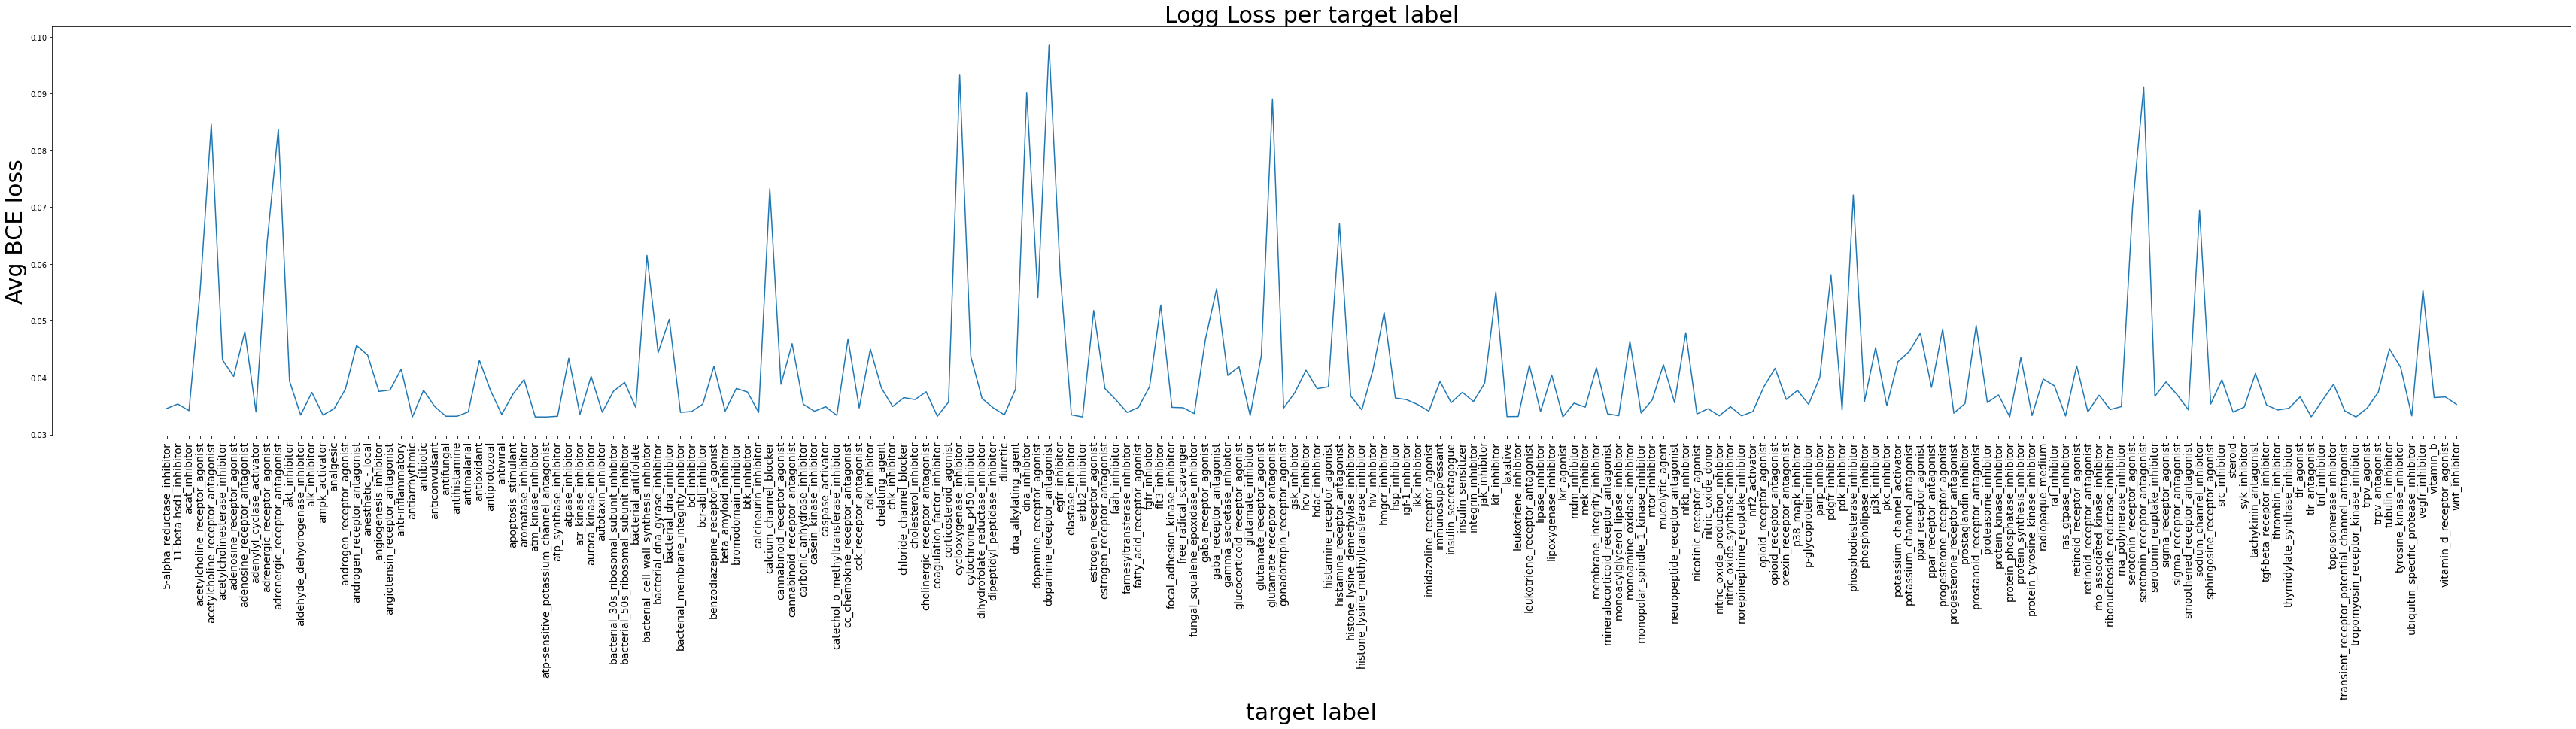

In [66]:
# Plotting test loss/label
plt.figure(figsize = (60,10))
plt.plot(target_names, data['test_losses'])
plt.title('Logg Loss per target label', fontsize = 30)
plt.xlabel('target label', fontsize=30)
plt.ylabel('Avg BCE loss', fontsize = 30)
plt.xticks(rotation = 90, fontsize = 14)
plt.show()

### 2. Plot of Pogression of Hamming Loss after each target label in the test dataset

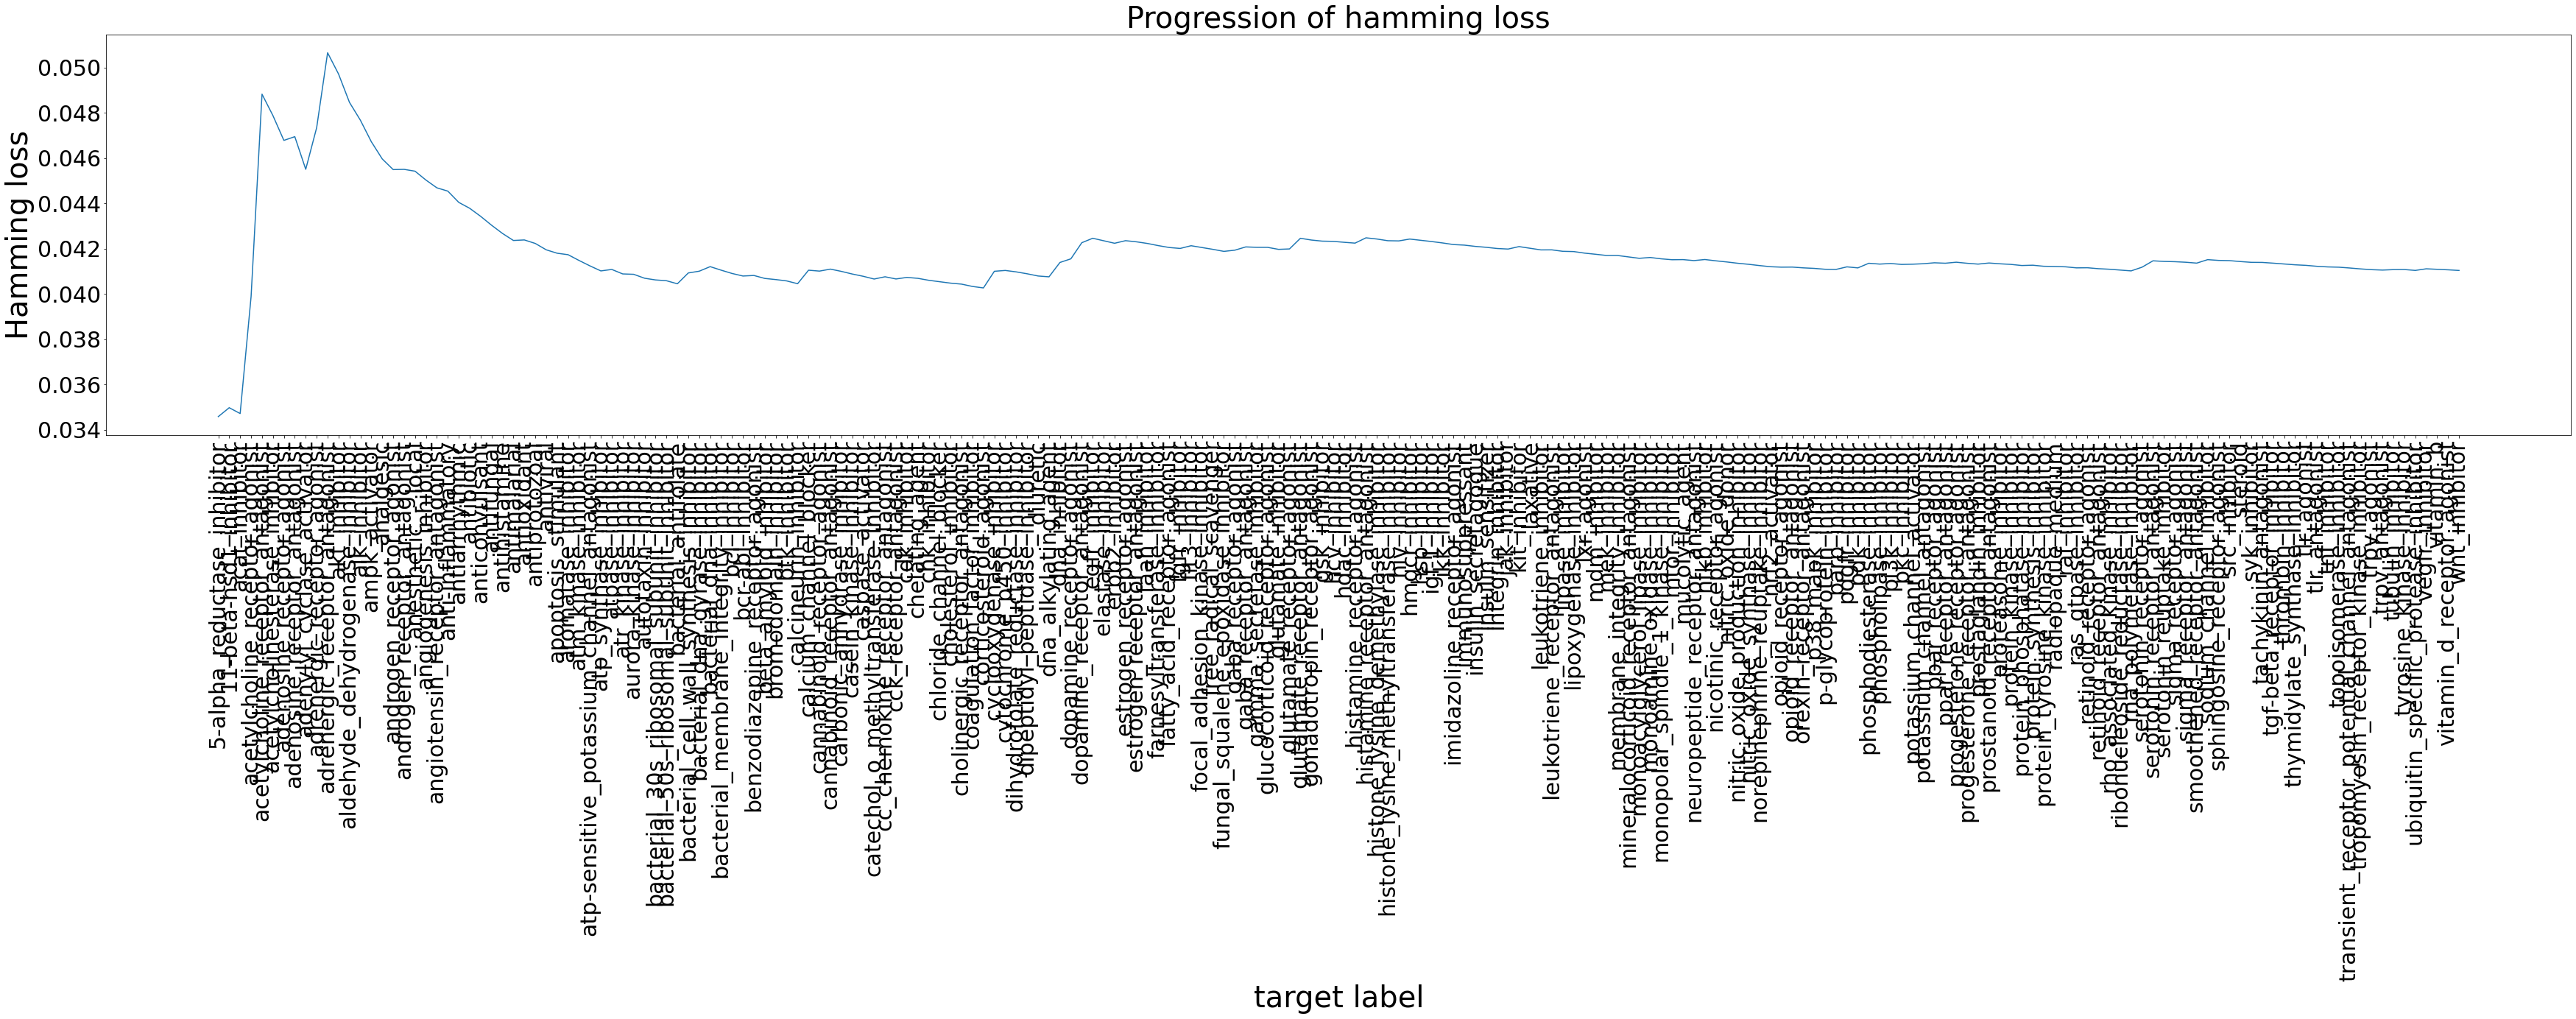

In [22]:
plt.figure(figsize = (60,10))
plt.plot(target_names, data['hamming_losses'])
plt.title('Progression of hamming loss', fontsize = 40)
plt.xlabel('target label', fontsize=40)
plt.ylabel('Hamming loss', fontsize = 40)
plt.xticks(rotation = 90, fontsize = 30)
plt.yticks(fontsize = 30)
plt.show()

### 3. Overall Hamming loss for the test set

In [23]:
print('Hamming loss for the test set: {}'.format(data['hamming_losses'][-1]))

Hamming loss for the test set: 0.041032233144372585


## Comparison of tuned GBT with untunted GBT

In [24]:
with open('data_tuned.pkl', 'rb') as f:
    data_tuned = pickle.load(f)

In [25]:
with open('data_untuned.pkl', 'rb') as f:
    data_untuned = pickle.load(f)

### 1. Comparing BCE loss per target label in test dataset

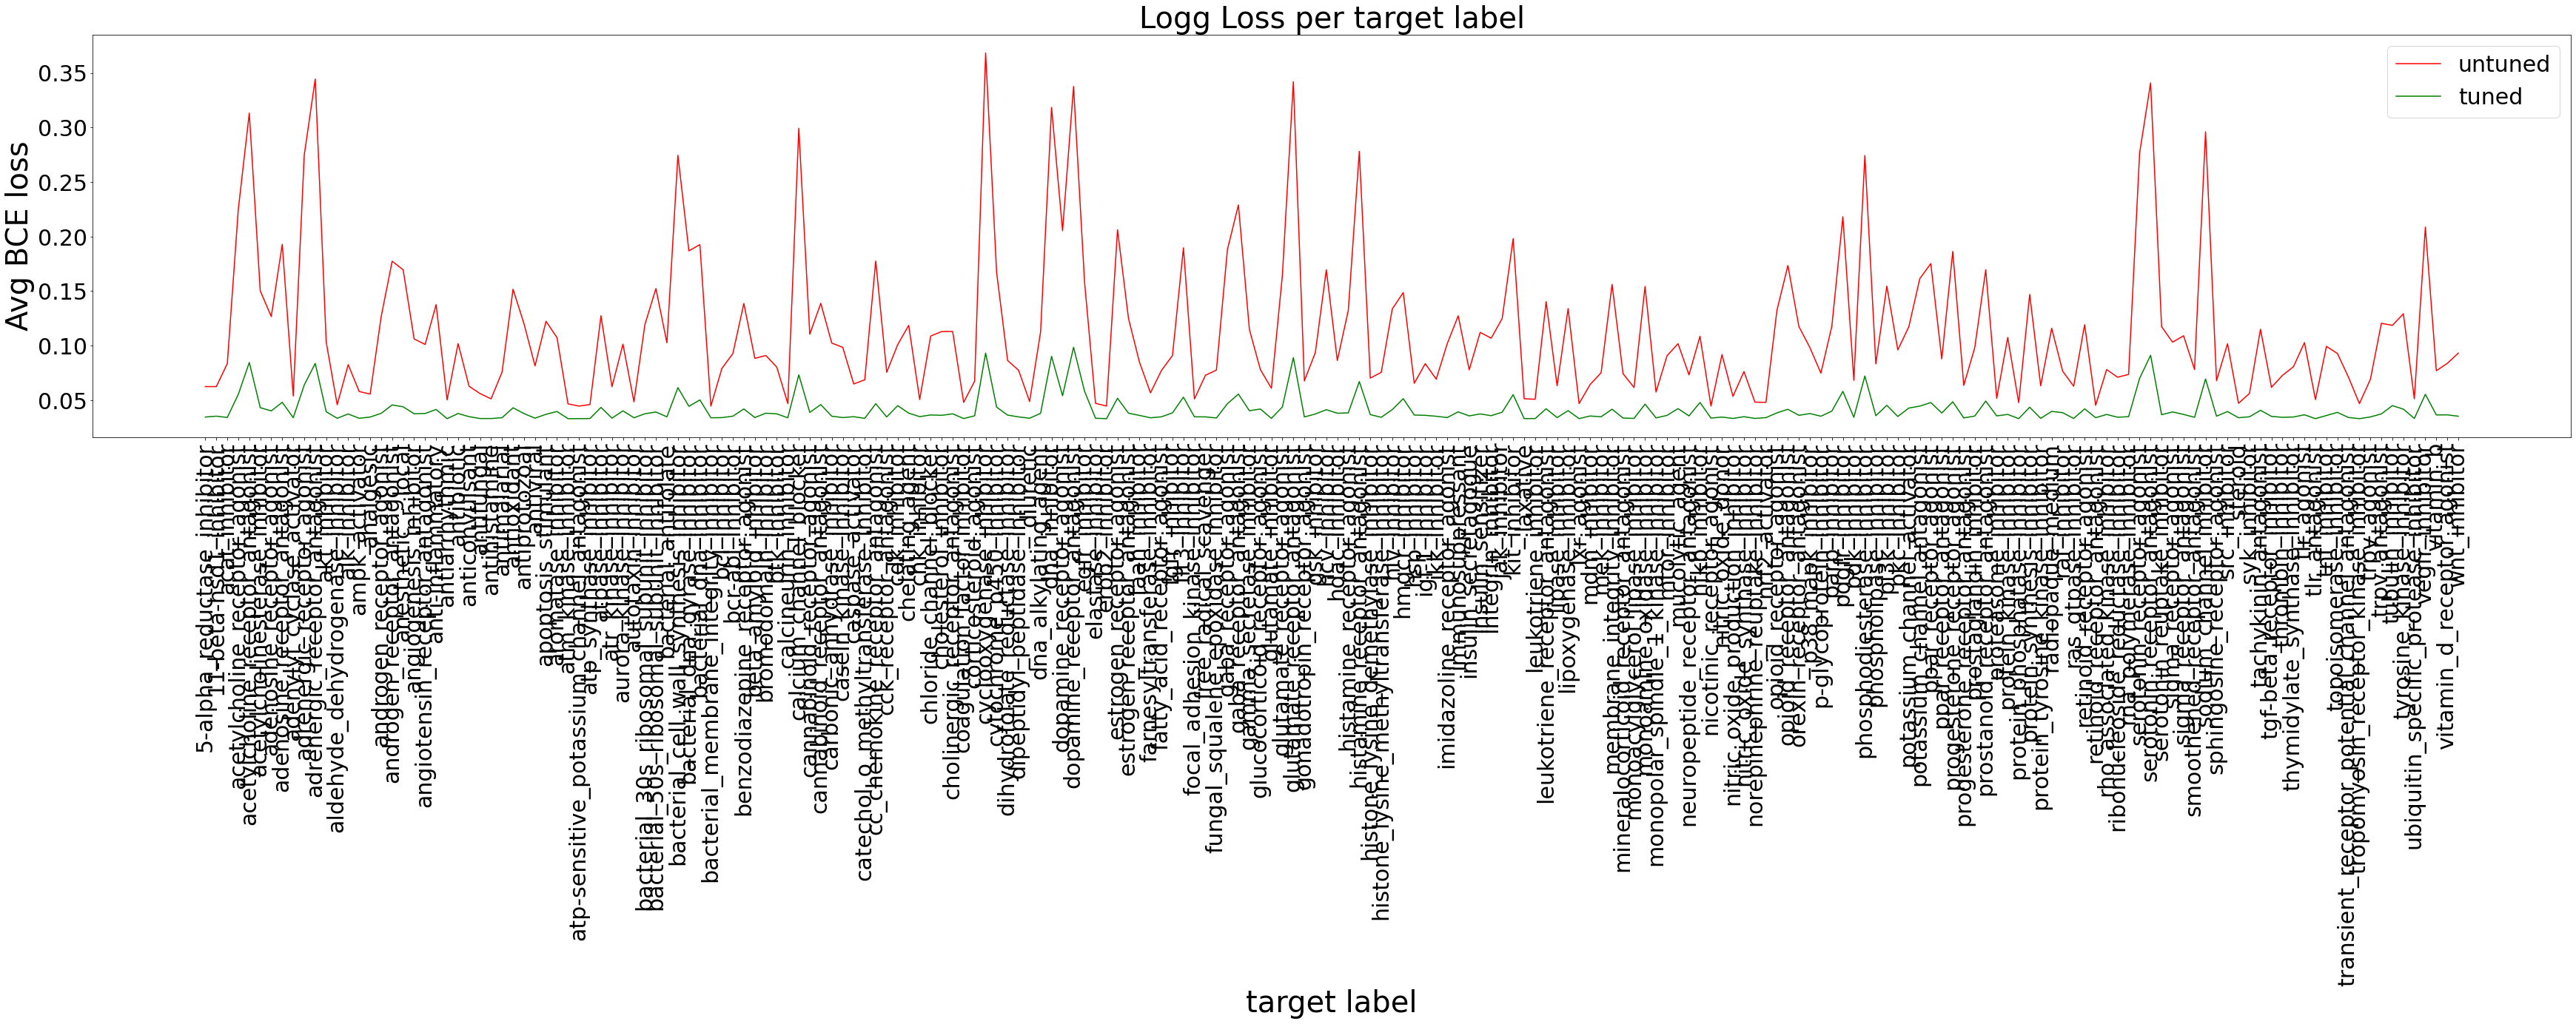

In [26]:
test_loss_tuned = data_tuned['test_losses']
test_loss_untuned = data_untuned['losses']
plt.figure(figsize = (60,10))
plt.plot(target_names, test_loss_untuned, color = 'red', label = 'untuned')
plt.plot(target_names, test_loss_tuned, color = 'green', label = 'tuned')
plt.title('Logg Loss per target label', fontsize = 40)
plt.xlabel('target label', fontsize=40)
plt.ylabel('Avg BCE loss', fontsize = 40)
plt.xticks(rotation = 90, fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)
plt.show()

### 2. Comparing Progression of Hamming Loss after each label in test data

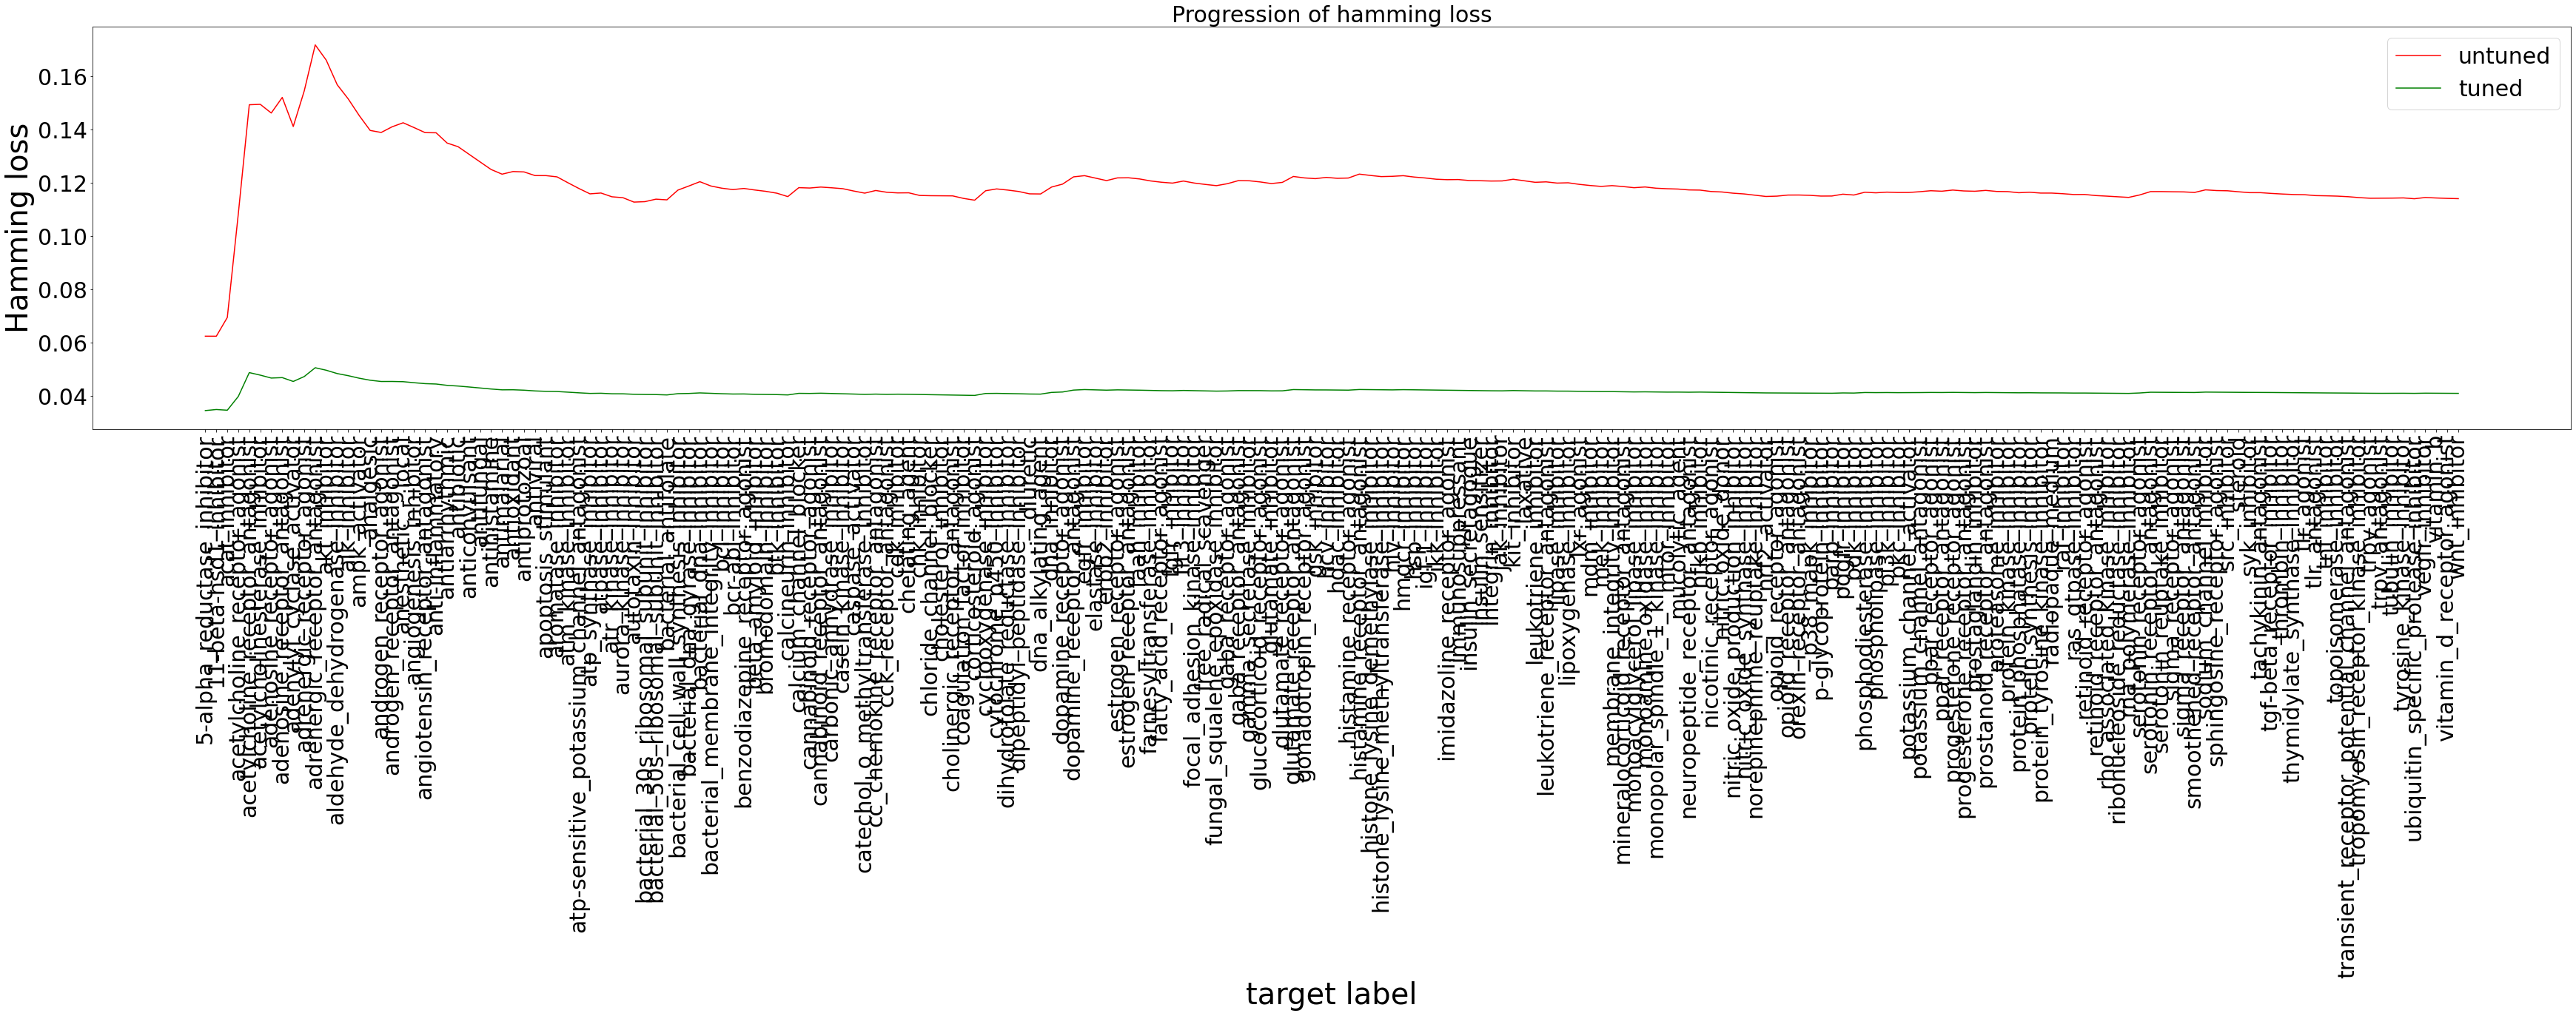

In [28]:
hamming_loss_tuned = data_tuned['hamming_losses']
hamming_loss_untuned = data_untuned['hamming_losses']

plt.figure(figsize = (60,10))
plt.plot(target_names, hamming_loss_untuned, color = 'red', label = 'untuned')
plt.plot(target_names, hamming_loss_tuned, color = 'green', label = 'tuned')
plt.title('Progression of hamming loss', fontsize = 30)
plt.xlabel('target label', fontsize=40)
plt.ylabel('Hamming loss', fontsize = 40)
plt.xticks(rotation = 90, fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)
plt.show()

### 3. Comparing Overall Hamming loss for the test set

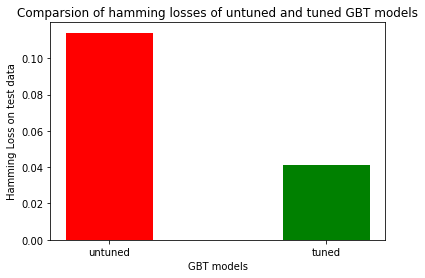

In [38]:
hamming_tuned = data_tuned['hamming_losses'][-1]
hamming_untuned = data_untuned['hamming_losses'][-1]
plt.bar([2,4], [hamming_untuned, hamming_tuned], color = ['red', 'green'], tick_label = ['untuned','tuned'])
plt.xlabel('GBT models')
plt.ylabel('Hamming Loss on test data')
plt.title('Comparsion of hamming losses of untuned and tuned GBT models')
plt.show()

### 4. Comparing of Hyperparameters [Iterations and Depth]

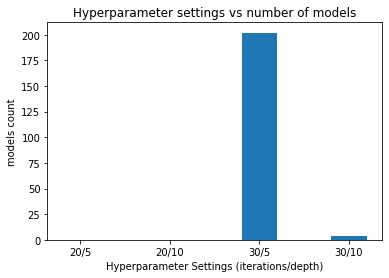

In [66]:
d = {'20/5': 0, '20/10': 0, '30/5': 0, '30/10': 0} # dictionary to store count of models using particular hyperparameter settings

for i in data_tuned['best_params']:    
    if i['maxIter'] == 20 and i['maxDepth'] == 5:
        d['20/5'] += 1
    elif i['maxIter'] == 20 and i['maxDepth'] == 10:
        d['20/10'] += 1
    elif i['maxIter'] == 30 and i['maxDepth'] == 5:
        d['30/5'] += 1
    else:
        d['30/10'] += 1
        
plt.bar([2,4,6, 8], list(d.values()), tick_label = list(d.keys()))
plt.xlabel('Hyperparameter Settings (iterations/depth)')
plt.ylabel('models count')
plt.title('Hyperparameter settings vs number of models')
plt.show()

### None of the models used default hyperparameter settings (iterations = 20, depth = 5). All the models had 30 iteration steps, while most of them had trees of depth 5 and some with depth 10

### Conclusion: 

1. As can be seen from the above plots, hamming loss reduces by more than 50% after tuninig the following hyperparameters: maximum iterations and maximum depth of trees. 

2. This can be attributed to the fact that default number of iterations and depth were 20 and 5 respectively. However, if number of iterations and depth of trees are increased then with addition of better functions, the overall loss comes down. 